In [65]:
# import libraries
import cv2
import numpy as np
import mediapipe as mp
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential,load_model,Model
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report
from keras.utils import plot_model

In [2]:
mp_holistic = mp.solutions.holistic # holistic model
mp_drawing = mp.solutions.drawing_utils # Initialize mediapipe drawing utilities

In [3]:
def detection (img, model):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert the input into RGB format to pass to mediapipe
    img.flags.writeable = False # To improve performance, mark the image as not writeable
    results = model.process(img) # detection model
    img.flags.writeable = True
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # convert the input into BGR format to pass to opencv imshow
    return img, results

In [4]:
def draw_landmarks (img, results):
    mp_drawing.draw_landmarks(img, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, mp_drawing.DrawingSpec(color=(255,128,0), thickness=2, circle_radius=2),mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(img, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, mp_drawing.DrawingSpec(color=(255,51,153), thickness=2, circle_radius=2),mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(img, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, mp_drawing.DrawingSpec(color=(255,51,153), thickness=2, circle_radius=2),mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=2))

In [5]:
# get webcam
cap = cv2.VideoCapture('./videoplayback.mp4')
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while True:
        ret, frame = cap.read()

        img, results = detection(frame, holistic) # make detectionq
        draw_landmarks(img,results) # draw landmarks

        cv2.imshow('Human Pose Estimation', img)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [6]:
# extracting body keypoints (features)
# flatten the array so that it can be passed to the LSTM model
def keypoint_extraction(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, left_hand, right_hand])

In [7]:
DATA_PATH = os.path.join('data') 
actions = ['punch', 'guard', 'normal'] # declare actions
vids_num = 30
vid_length = 30 #frames

In [ ]:
# data directory
for action in actions:
    for vid in range(vids_num):
        os.makedirs(os.path.join('data', action, str(vid)))

In [8]:
# collecting data
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for vid in range(vids_num):
            for frame_num in range(vid_length):
                ret, frame = cap.read()

                img, results = detection(frame, holistic)
                draw_landmarks(img,results) 

                if frame_num == 0: 
                    cv2.putText(img, 'Start collecting', (120,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(img, 'Collecting frames for {} Video Number {}'.format(action, vid), (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', img)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(img, 'Collecting frames for {} Video Number {}'.format(action, vid), (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', img)
                
                keypoints = keypoint_extraction(results)
                npy_path = os.path.join(DATA_PATH, action, str(vid), str(frame_num))
                np.save(npy_path, keypoints)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    cap.release()
    cv2.destroyAllWindows()

In [8]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'punch': 0, 'guard': 1, 'normal': 2}

In [32]:
# save each frame in a numpy array
sequences, labels = [], []
for action in actions:
    for vid in range(vids_num):
        window = []
        for frame_num in range(vid_length):
            res = np.load(os.path.join(DATA_PATH, action, str(vid), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [33]:
print(np.array(sequences).shape)
print(np.array(labels).shape)

(90, 30, 258)
(90,)


In [34]:
# dataset
X = np.array(sequences)
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print('X_train shape: ', X_train.shape)
print('y_train shape: ',y_train.shape)
print('X_test shape: ',X_test.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (81, 30, 258)
y_train shape:  (81, 3)
X_test shape:  (9, 30, 258)
y_test shape:  (9, 3)


In [78]:
# LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=False, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 30, 64)            82688     
                                                                 
 dropout_34 (Dropout)        (None, 30, 64)            0         
                                                                 
 lstm_22 (LSTM)              (None, 30, 128)           98816     
                                                                 
 dropout_35 (Dropout)        (None, 30, 128)           0         
                                                                 
 lstm_23 (LSTM)              (None, 256)               394240    
                                                                 
 batch_normalization_5 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                      

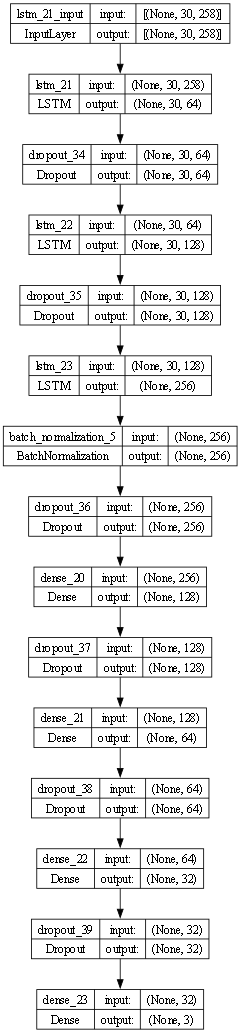

In [79]:
plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [80]:
# compile the model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=["accuracy"])

checkpoint = ModelCheckpoint("./Action_recognition_LSTM.model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_acc',min_delta=0, patience=3, verbose=1, restore_best_weights=True)

reduce_learningrate = ReduceLROnPlateau(monitor='val_acc',factor=0.2, patience=3, verbose=1, min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

In [81]:
history = model.fit(X_train, y_train, batch_size= 16, validation_data=(X_test,y_test), epochs=50, verbose=1, callbacks=callbacks_list)

Epoch 1/50
6/6 [==============================] - 4s 147ms/step - loss: 1.1141 - accuracy: 0.4321 - val_loss: 1.0819 - val_accuracy: 0.5556 - lr: 0.0100
Epoch 2/50
6/6 [==============================] - 0s 45ms/step - loss: 0.9299 - accuracy: 0.5432 - val_loss: 1.0805 - val_accuracy: 0.5556 - lr: 0.0100
Epoch 3/50
6/6 [==============================] - 0s 42ms/step - loss: 0.8408 - accuracy: 0.6049 - val_loss: 1.0485 - val_accuracy: 0.5556 - lr: 0.0100
Epoch 4/50
6/6 [==============================] - 0s 43ms/step - loss: 0.7459 - accuracy: 0.6914 - val_loss: 1.0185 - val_accuracy: 0.5556 - lr: 0.0100
Epoch 5/50
6/6 [==============================] - 0s 48ms/step - loss: 0.7650 - accuracy: 0.7654 - val_loss: 1.0203 - val_accuracy: 0.5556 - lr: 0.0100
Epoch 6/50
6/6 [==============================] - 0s 46ms/step - loss: 0.6210 - accuracy: 0.7160 - val_loss: 1.0026 - val_accuracy: 0.6667 - lr: 0.0100
Epoch 7/50
6/6 [==============================] - 0s 42ms/step - loss: 0.5165 - accurac

In [82]:
# prediction & evaluation
results= model.evaluate(X_test,y_test)
preds = model.predict(X_test)
print(' Model accuracy {}%'.format(round(results[1]*100, 2)))

1/1 [==============================] - 0s 436ms/step
 Model accuracy 100.0%


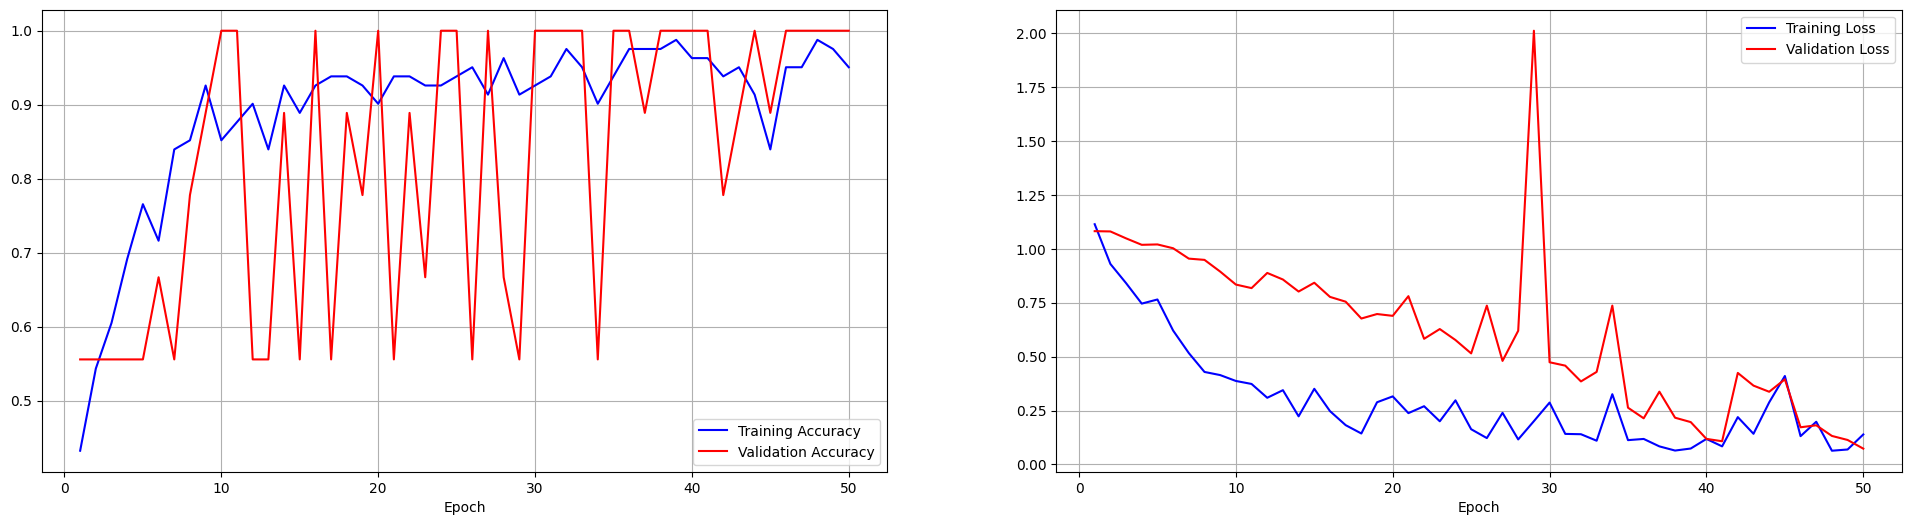

In [83]:
# visualise training and testing accuracy & loss
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(24, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()


plot_results(history)

In [84]:
model.save('Action_recognition_LSTM.model.h5')

c:\Users\D.azad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [85]:
#Test  model
my_Res_model = load_model('./Action_recognition_LSTM.model.h5', compile=False)

predictions_Res = my_Res_model.predict(X_test)
y_pred_Res=np.argmax(predictions_Res, axis=1)
y_test_p = np.argmax(y_test, axis=1)
print ("Accuracy = ", metrics.accuracy_score(y_test_p, y_pred_Res))

1/1 [==============================] - 0s 473ms/step
Accuracy =  1.0


<Axes: >

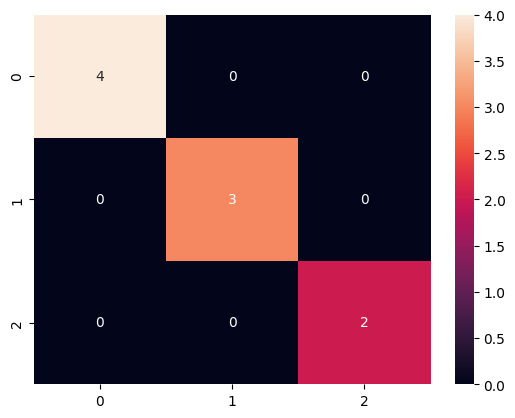

In [86]:
# confusion matrix
cm=confusion_matrix(y_test_p, y_pred_Res)  
sns.heatmap(cm, annot=True)

In [87]:
ClassificationReport = classification_report(y_test_p,y_pred_Res)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



In [88]:
# test in real-time
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    return output_frame

In [89]:
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()

        image, results = detection(frame, holistic)
        draw_landmarks(image, results)
        keypoints = keypoint_extraction(results)

        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti